## Import necessary libraries

In [2]:
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import preprocess_kgptalkie as ps
import gensim
import timeit
import warnings
warnings.filterwarnings("ignore")

# Tensorflow - Keras
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## Importing datasets and performing exploratory data analysis

#### Fake News Dataset

In [2]:
fake_news = pd.read_csv("data/Fake.csv")

In [3]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


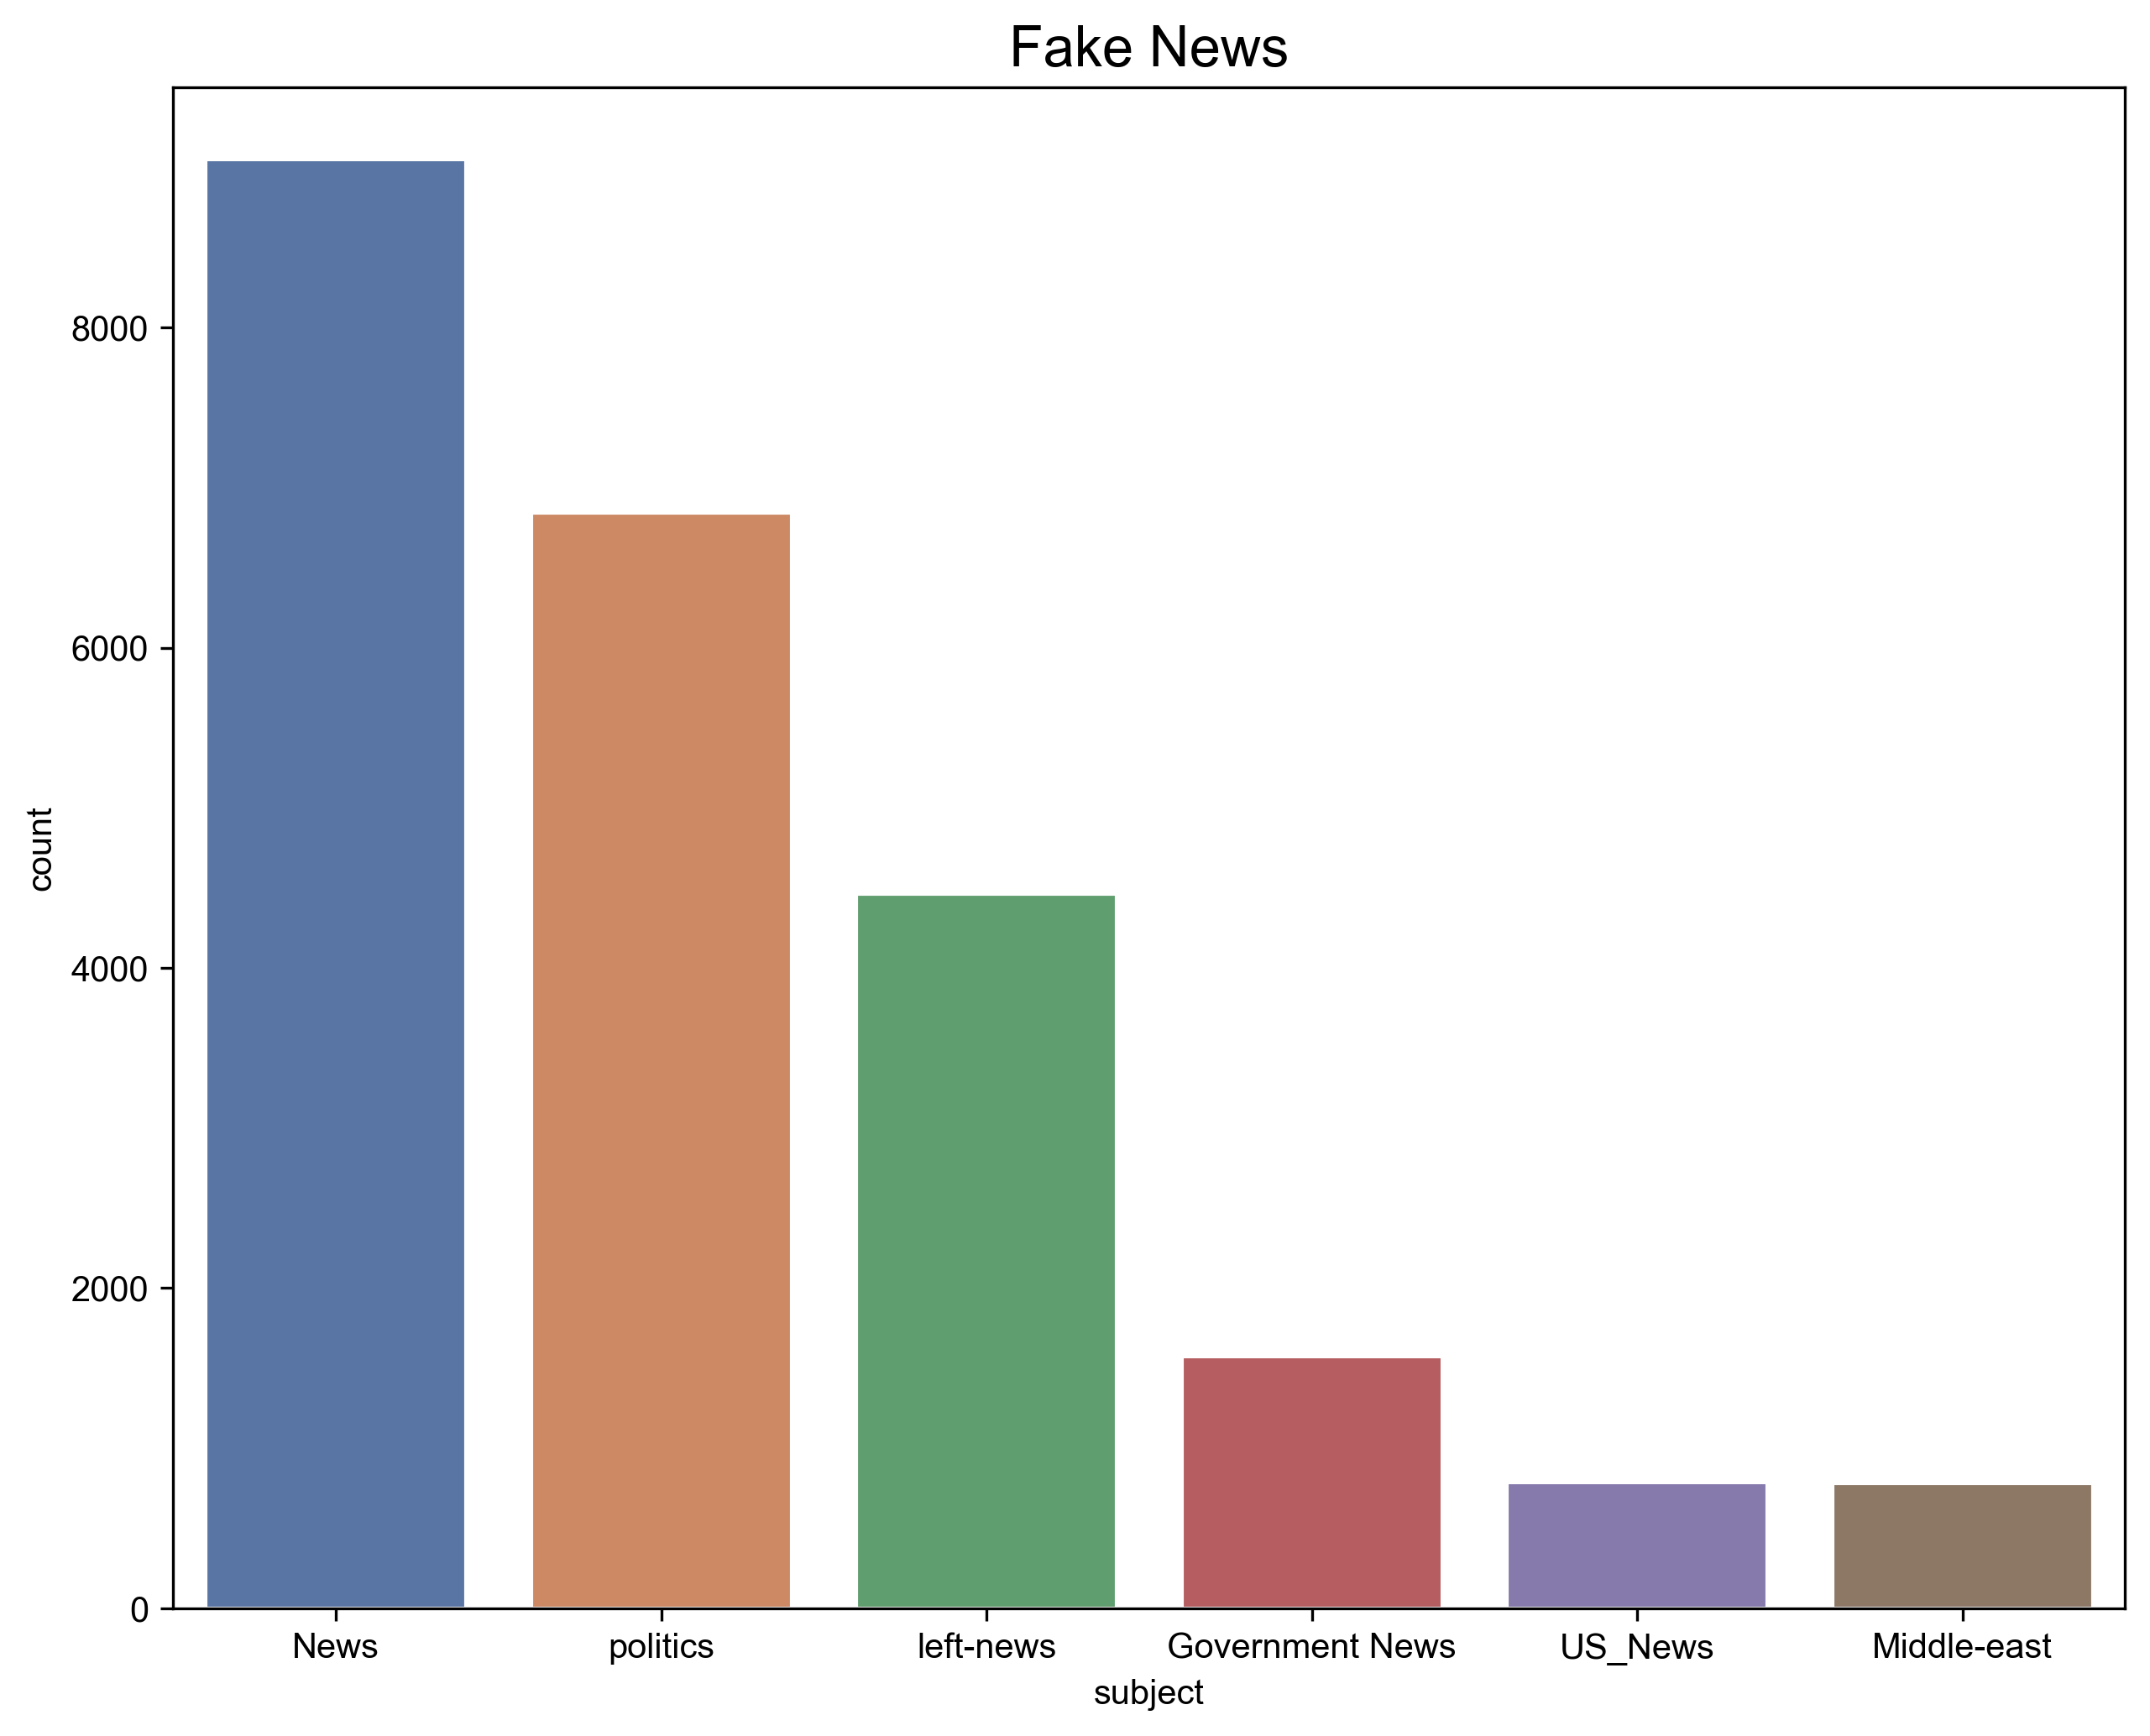

In [4]:
# Plot the counts of its subject on fake dataset with descending order
plt.figure(figsize=(10, 8), dpi=300)
plt.title("Fake News", fontsize=16)
sns.set(style='whitegrid')
sns.countplot(x="subject", 
              data=fake_news,
              order=fake_news["subject"].value_counts().index);
plt.show()

In [5]:
# Merge all fake data together to visualize it using the WordCloud library
fake_text = ' '.join(fake_news["text"].tolist())

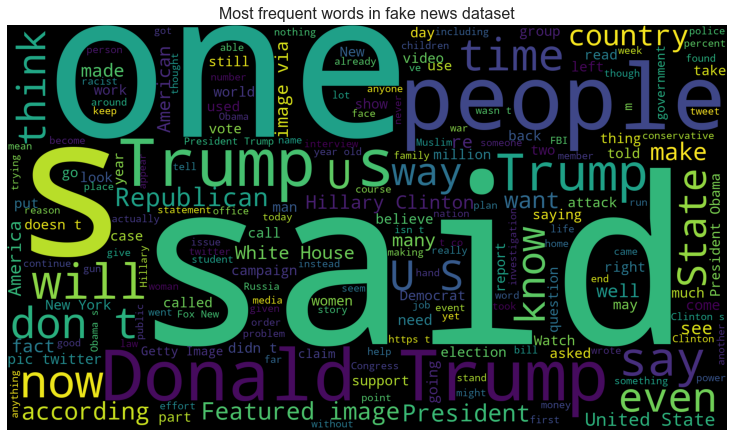

In [6]:
# Fake text data visualization using the WordCloud library
wordcloud = WordCloud(width=1920, height=1080).generate(fake_text)
fig = plt.figure(figsize=(10, 8))
plt.axis("off")
plt.title("Most frequent words in fake news dataset", fontsize=16)
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

#### Real News Dataset

In [7]:
real_news = pd.read_csv("data/True.csv")

In [8]:
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


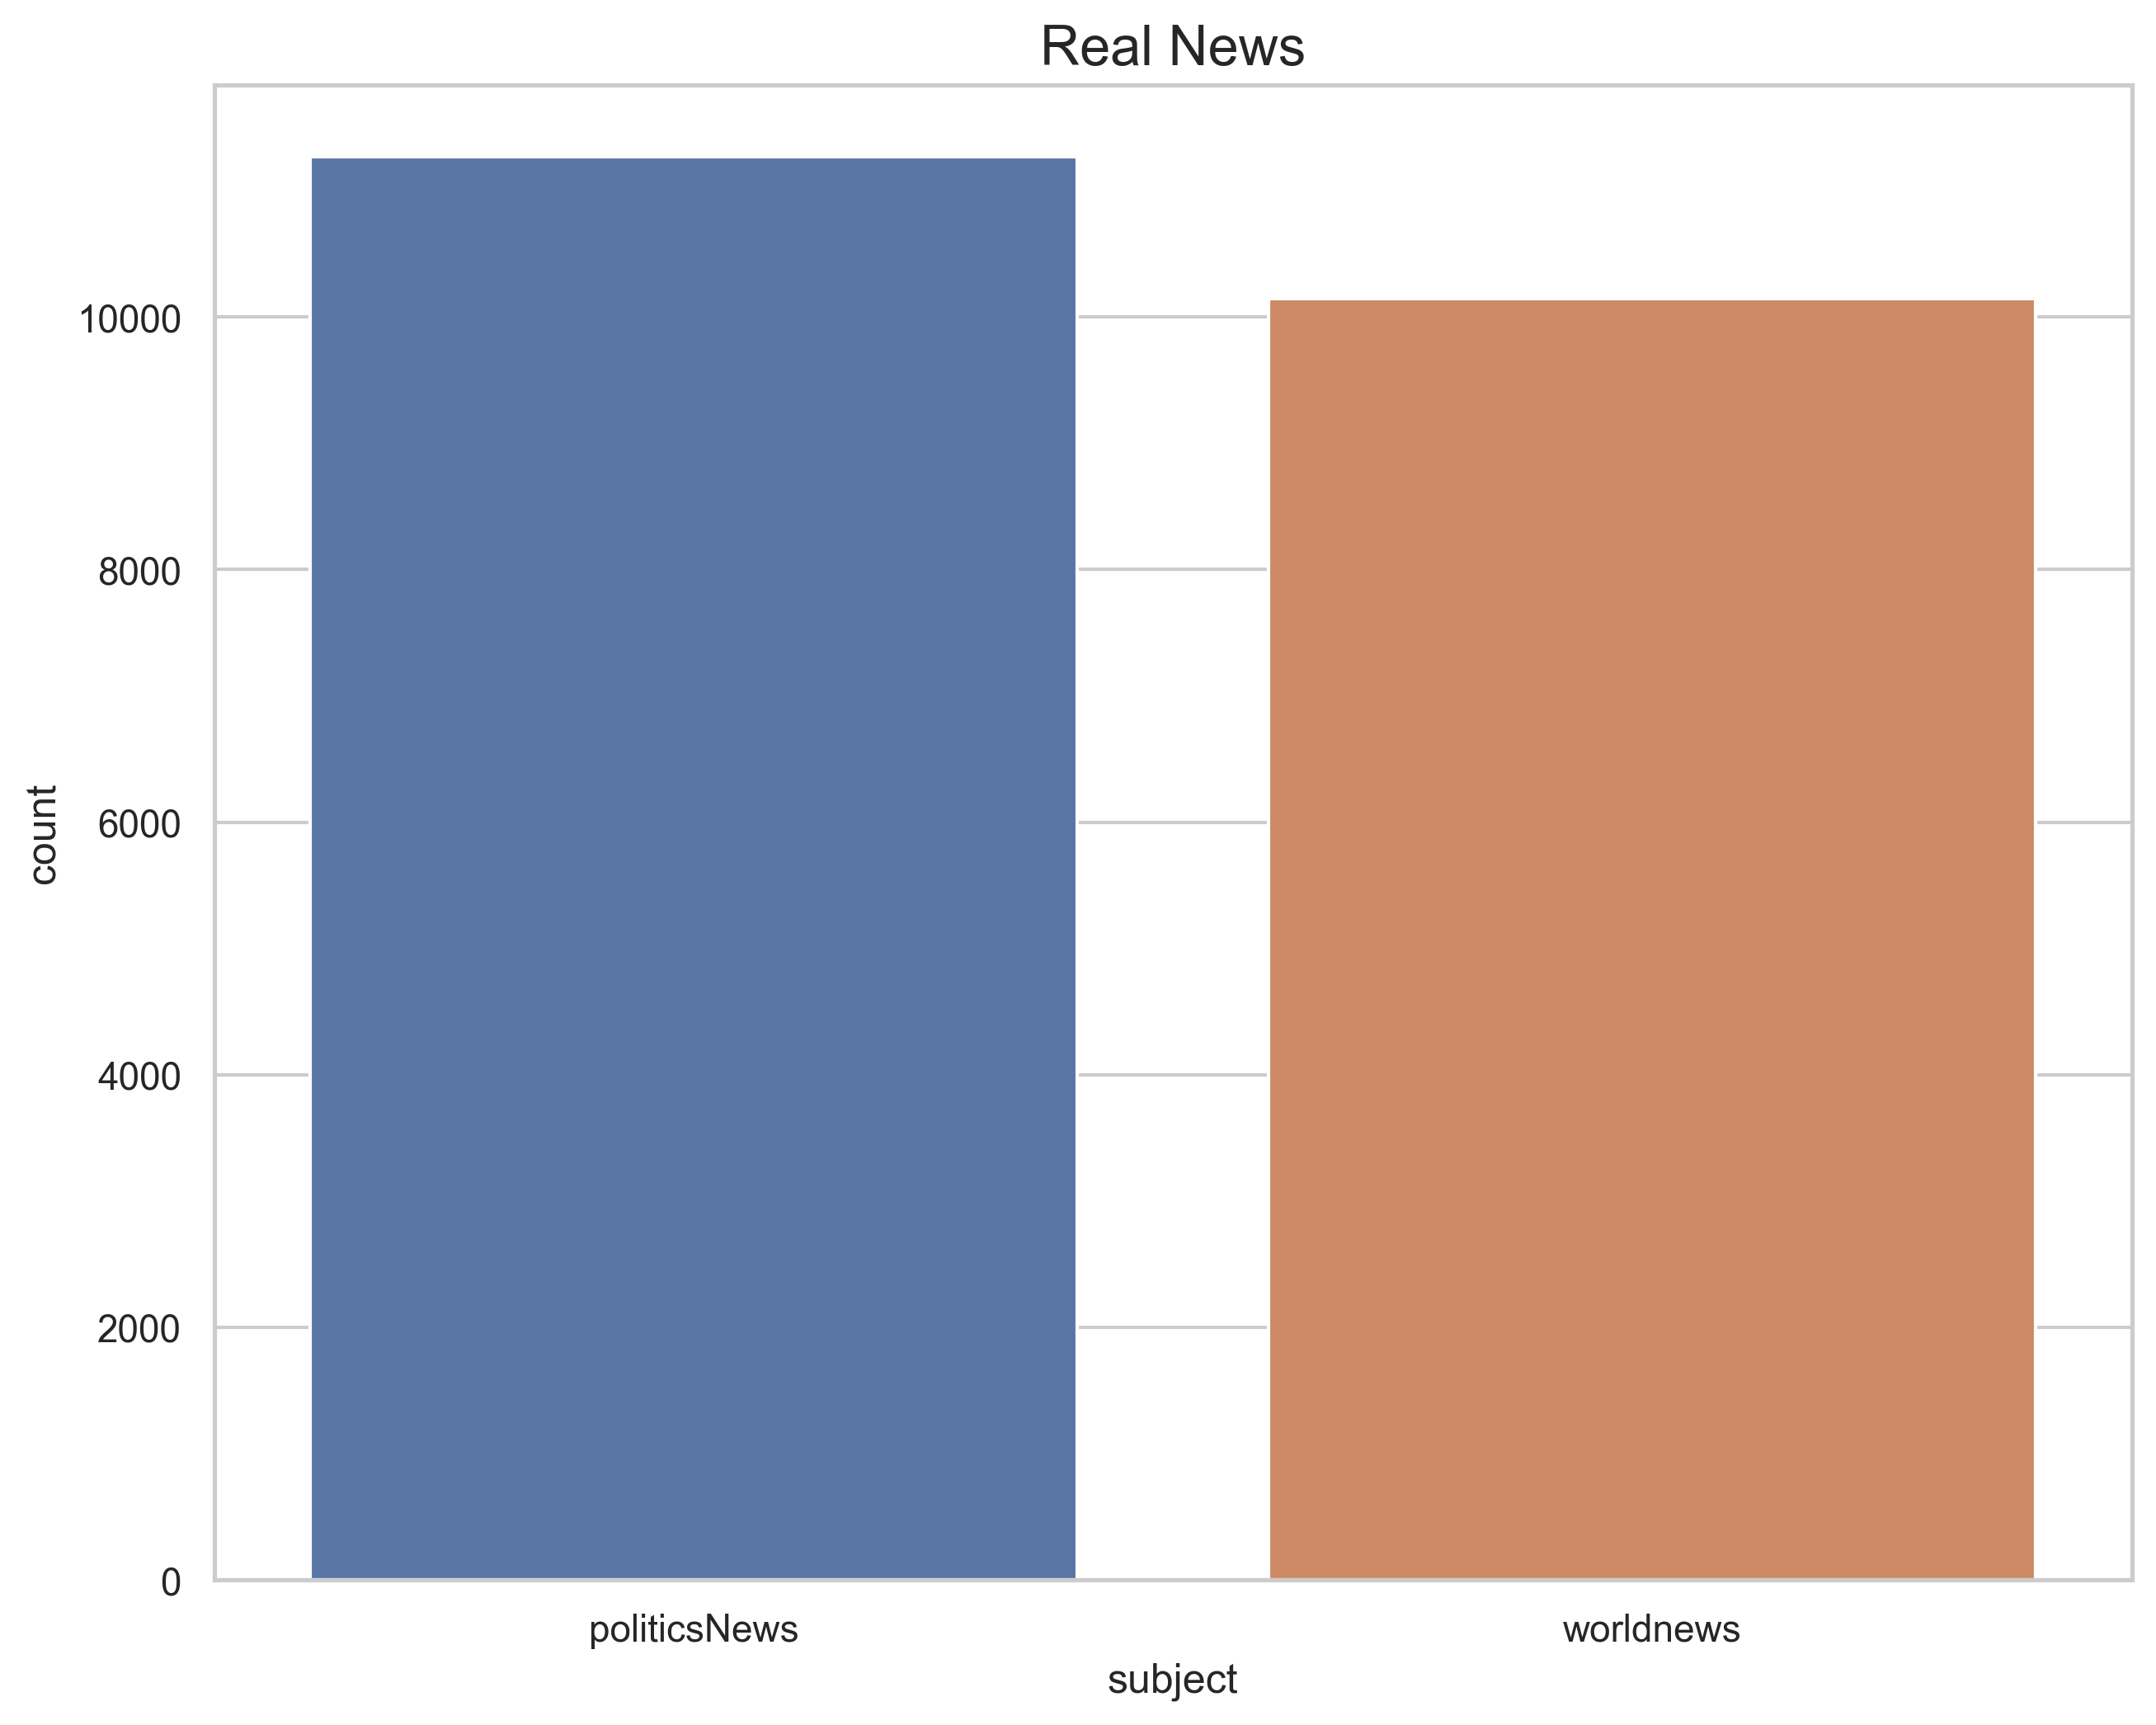

In [9]:
# Plot the counts of its subject on real dataset with descending order
plt.figure(figsize=(10, 8), dpi=300)
sns.set(style='whitegrid')
plt.title("Real News", fontsize=16)
sns.countplot(x="subject", 
              data=real_news,
              order=real_news["subject"].value_counts().index);
plt.show()

In [10]:
# Merge all real data together to visualize it using the WordCloud library
real_text = ' '.join(real_news["text"].tolist())

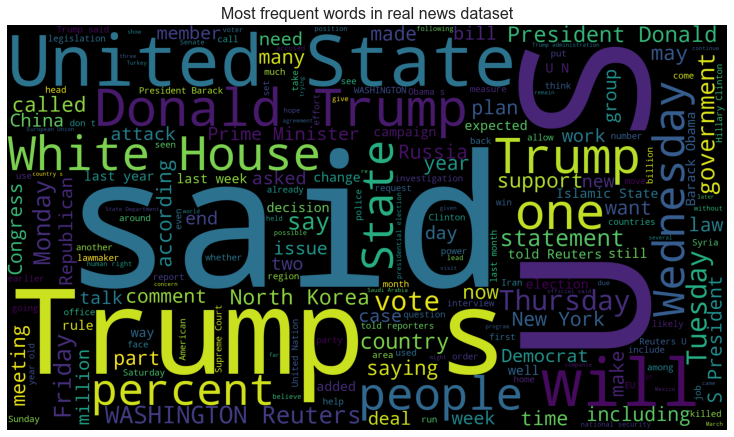

In [11]:
# Real text data visualization using the WordCloud library
wordcloud = WordCloud(width=1920, height=1080).generate(real_text)
fig = plt.figure(figsize=(10, 8))
plt.axis("off")
plt.title("Most frequent words in real news dataset", fontsize=16)
plt.tight_layout(pad=0)
plt.imshow(wordcloud)
plt.show()

Difference in text on
real news seems to have source of publication which is not present in fake news set

Looking at the data:
- Most of text contains reuters information such as "WASHINGTON (Reuters)"
- Some text are tweets from Twitter
- Few text do not contain any publication info

## Cleaning Data

Removing reuters or tweets information from the text
- Text can be splitted only once at "-" which is always present after mentioning source of publication, this gives us publication part and text part
- If we do not get text part, this means publication details wasn't given for that record
- The Twitter tweets always have same source, a long text of max 120 characters

In [12]:
# Get indexes of all rows which are tweets from Twitter (length of chars bigger than 120) 
# or they have unknown publishers
unidentified_publishers = []
for index, record in enumerate(real_news["text"]):
    try:
        value = record.split("-")
        value[1]
        assert(len(value[0]) < 120)
    except:
        unidentified_publishers.append(index)

In [15]:
# Convert any empty string (" ") on fake dataset to NaN
fake_news.replace(" ", np.nan, inplace=True)
# Convert any empty string (" ") on real dataset to NaN
real_news.replace(" ", np.nan, inplace=True)

In [16]:
# Drop rows from fake dataset if their text column is empty
fake_news.dropna(subset = ["text"], axis=0, inplace=True)
# Drop rows from real dataset if their text column is empty
real_news.dropna(subset = ["text"], axis=0, inplace=True)

In [17]:
# Extract publisher information from the text data and save it to a new column
publishers = []
texts = []

for index, record in enumerate(real_news["text"]):
    if index not in unidentified_publishers:
        value = record.split("-")
        publishers.append(value[0].strip())
        texts.append(value[1].strip())
    else:
        publishers.append('Unknown')
        texts.append(record)

real_news["text"] = texts       
real_news["publisher"] = publishers

In [18]:
real_news.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [19]:
# Merge title and text columns of fake dataset on text column
fake_news["text"] = fake_news["title"] + " " + fake_news["text"]
# Merge title and text columns of real dataset on text column
real_news["text"] = real_news["title"] + " " + real_news["text"]

In [20]:
# Lowercasing the text column of fake dataset
fake_news["text"] = fake_news["text"].str.lower()
# Lowercasing the text column of real dataset
real_news["text"] = real_news["text"].str.lower()

In [21]:
real_news.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...","as u.s. budget fight looms, republicans flip t...",politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,u.s. military to accept transgender recruits o...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,senior u.s. republican senator: 'let mr. muell...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,fbi russia probe helped by australian diplomat...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,trump wants postal service to charge 'much mor...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [22]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends out embarrassing new year’...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian ...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes an internet joke...,News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump is so obsessed he even has obama’s name...,News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis just called out donald trump dur...,News,"December 25, 2017"


## Preprocessing Text

In [23]:
# Create the class column for fake and real dataset
fake_news["class"] = 0
real_news["class"] = 1

In [24]:
# Combine fake and real dataset together
fake_news = fake_news[["text", "class"]]
real_news = real_news[["text", "class"]]
data = pd.concat([fake_news, real_news])

In [25]:
data.sample(5)

,text,class
20412,racist oprah makes same mistake…twice just rem...,0
1906,senate dems now have the votes to f*ck gorsuc...,0
19059,van jones guarantees 8 years of president trum...,0
13146,japan wants missiles with enough range to stri...,1
12699,polish lower house of parliament backs judicia...,1


In [26]:
# Remove special characters like (,.#@)

# !pip install spacy==2.2.3
# !python -m spacy download en_core_web_sm
# !pip install beautifulsoup4==4.9.1
# !pip install textblob==0.15.3
# !pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall

data["text"] = data["text"].apply(lambda value: ps.remove_special_chars(value))

## Word2Vec - Vectorization Method

In [27]:
# !pip install -U gensim

In [28]:
# Getting the feature variable
X = [doc.split() for doc in data["text"].tolist()]
# Getting the target variable
y = data["class"]

In [29]:
# Convert each word into a sequence of 100 vectors
DIM = 100
word2vec_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, min_count=1, window=10)

In [33]:
# Convert each word of text data into a sequence like (1, 2, 3, 4, 5)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X = tokenizer.texts_to_sequences(X)

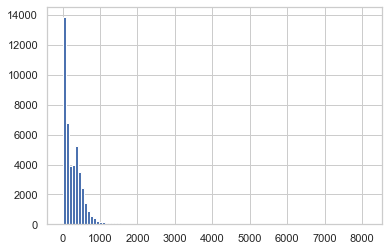

In [34]:
# How many words are presenting in each row
plt.hist([len(seq_words) for seq_words in X], bins=100)
plt.show()

In [35]:
# Count of news which are more than 1000 words
nos = np.array([len(words) for words in X])
len(nos[nos > 1000])

1051

In [36]:
# Make every sequence at the length of 1000 words
# When a sequence is greater than 1000 that is truncated
# When a sequence is less than 1000 then zeros are added in the beginning of each sequence 
# until each sequence has the same length as the longest sequence.
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [38]:
# Because many words which might not come in these tokens so for those the machine learning model
# will consider that as unknown word and for that unknown word a sequence will be created.
# Adding 1 for the unknown words
vocabulary_size = len(tokenizer.word_index) + 1

# Create a variable to store the vocabulary
vocabulary = tokenizer.word_index

In [39]:
# Get the weight vectors
def get_weight_matrix(model):
    # Initialize a matrix of weights with the size of vocabulary_size variable 
    # and dimensions of DIM variable
    weight_matrix = np.zeros((vocabulary_size, DIM))
    
    for word, index in vocabulary.items():
        weight_matrix[index] = model.wv[word]
    
    return weight_matrix

In [40]:
embedding_vectors = get_weight_matrix(word2vec_model)

## Split dataset to train and test sets

In [42]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=42)

## Definition of the function for training and evaluating model 

In [43]:
def train_evaluate_model(model, library):
    # Train the model
    start = timeit.default_timer()
    if library == "tensorflow":
        model.summary()
        model.fit(x_train, y_train, epochs=100, validation_split=0.3, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    else:
        model.fit(x_train, y_train)
    stop = timeit.default_timer()
    
    print(f"Total Training Time: {stop - start}\n")  
    
    # Evaluate the model
    # If each probability is equal or greater than 0.5 then it will be convert it into 1.
    # Otherwise it will be convert it into 0
    y_pred = (model.predict(x_test) >= 0.5).astype(int)
    print(classification_report(y_test, y_pred))
    
    sns.heatmap(confusion_matrix(y_test,y_pred), 
                annot=True, 
                fmt="g",
                xticklabels=["FAKE", "REAL"],
                yticklabels=["FAKE", "REAL"])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## LSTM Model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         20107500  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 20,224,877
Trainable params: 20,224,877
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
727/727 [==============================] - 78s 97ms/step - loss: 0.1013 - accuracy: 0.9639 - val_loss: 0.0331 - val_accuracy: 0.9884
Epoch 2/100
727/727 [==============================] - 60s 83ms/step - loss: 0.0242 - accuracy: 0.9916 - val_loss: 0.0230 - val_accuracy: 0.9929
Epoch 3/100
727/72

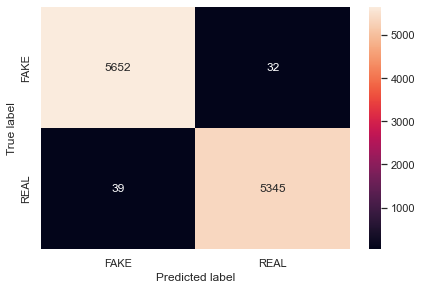

In [45]:
model = Sequential()
model.add(
        Embedding(input_dim=vocab_size, 
                  input_length=maxlen, 
                  output_dim=DIM, 
                  weights = [embedding_vectors],
                  trainable=True
                 )
    )
model.add(LSTM(units=128))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

train_evaluate_model(model, "tensorflow")

## Bidirectional LSTM Model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1000, 100)         20107500  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 20,342,253
Trainable params: 20,342,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
727/727 [==============================] - 109s 147ms/step - loss: 0.1270 - accuracy: 0.9546 - val_loss: 0.1273 - val_accuracy: 0.9566
Epoch 2/100
727/727 [==============================] - 104s 144ms/step - loss: 0.0442 - accur

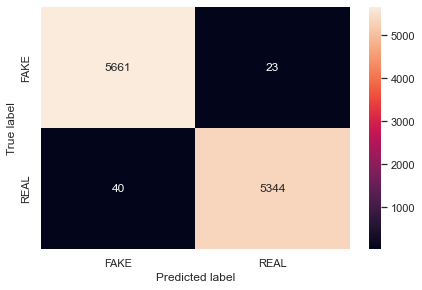

In [46]:
model = Sequential()
model.add(
        Embedding(input_dim=vocab_size, 
                  input_length=maxlen, 
                  output_dim=DIM, 
                  weights = [embedding_vectors],
                  trainable=True
                 )
    )
model.add(Bidirectional(LSTM(units=128)))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

train_evaluate_model(model, "tensorflow")

## Gaussian Naive Bayes

Total Training Time: 0.4387562000001708

              precision    recall  f1-score   support

           0       0.97      0.69      0.81      5684
           1       0.75      0.98      0.85      5384

    accuracy                           0.83     11068
   macro avg       0.86      0.84      0.83     11068
weighted avg       0.86      0.83      0.83     11068



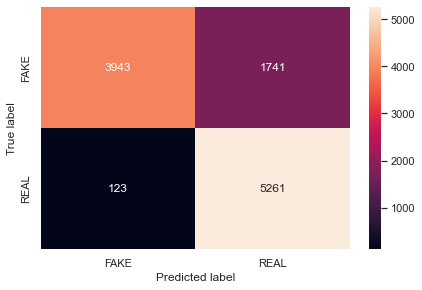

In [47]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
train_evaluate_model(model, "sklearn")

## Random Forests

Total Training Time: 27.450000099999897

              precision    recall  f1-score   support

           0       0.90      0.93      0.92      5684
           1       0.93      0.89      0.91      5384

    accuracy                           0.91     11068
   macro avg       0.91      0.91      0.91     11068
weighted avg       0.91      0.91      0.91     11068



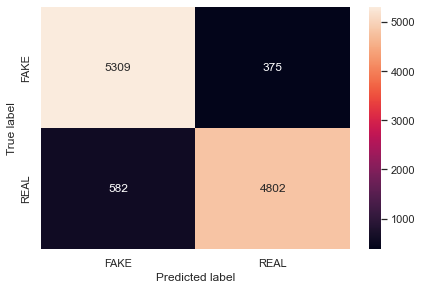

In [48]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
train_evaluate_model(model, "sklearn")

## Decision Trees

Total Training Time: 11.465392800000245

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      5684
           1       0.90      0.88      0.89      5384

    accuracy                           0.90     11068
   macro avg       0.90      0.90      0.90     11068
weighted avg       0.90      0.90      0.90     11068



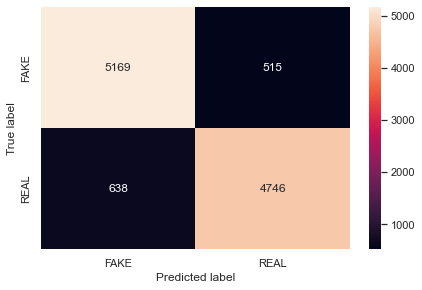

In [49]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
train_evaluate_model(model, "sklearn")

## Logistic Regression

Total Training Time: 3.2607395999998516

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      5684
           1       0.84      0.78      0.81      5384

    accuracy                           0.82     11068
   macro avg       0.83      0.82      0.82     11068
weighted avg       0.82      0.82      0.82     11068



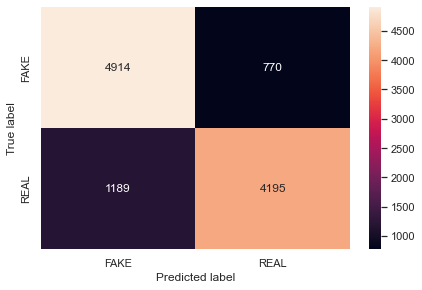

In [50]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
train_evaluate_model(model, "sklearn")

## Linear Support Vector Machine

Total Training Time: 19.425145600000178

              precision    recall  f1-score   support

           0       0.64      0.75      0.69      5684
           1       0.68      0.56      0.61      5384

    accuracy                           0.66     11068
   macro avg       0.66      0.65      0.65     11068
weighted avg       0.66      0.66      0.65     11068



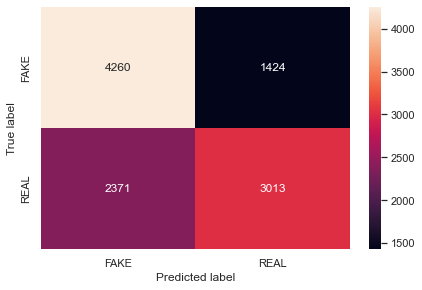

In [51]:
from sklearn.svm import LinearSVC
model = LinearSVC()
train_evaluate_model(model, "sklearn")

## K-nearest Neighbors

Total Training Time: 0.0019147000002703862

              precision    recall  f1-score   support

           0       0.94      0.40      0.56      5684
           1       0.60      0.98      0.75      5384

    accuracy                           0.68     11068
   macro avg       0.77      0.69      0.65     11068
weighted avg       0.78      0.68      0.65     11068



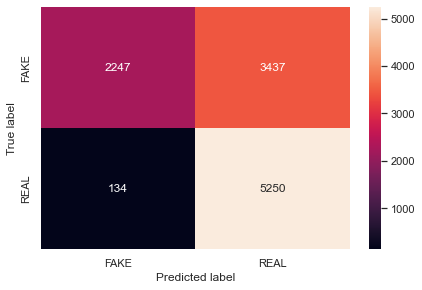

In [52]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
train_evaluate_model(model, "sklearn")

## Ada Boost

Total Training Time: 62.282793200000015

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5684
           1       0.88      0.90      0.89      5384

    accuracy                           0.89     11068
   macro avg       0.89      0.89      0.89     11068
weighted avg       0.89      0.89      0.89     11068



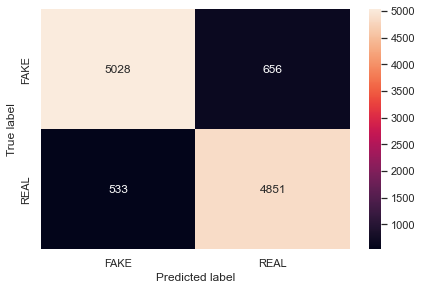

In [53]:
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
train_evaluate_model(model, "sklearn")

## XGboost 

Total Training Time: 17.003023700000085

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5684
           1       0.93      0.95      0.94      5384

    accuracy                           0.94     11068
   macro avg       0.94      0.94      0.94     11068
weighted avg       0.94      0.94      0.94     11068



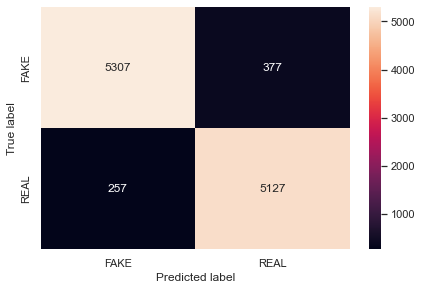

In [56]:
from xgboost import XGBClassifier
model = XGBClassifier(eval_metric="mlogloss")
train_evaluate_model(model, "sklearn")

## Voting Classifier (Random Forests, Logistic Regression, KNN)

Total Training Time: 34.99585279999974

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      5684
           1       0.87      0.90      0.89      5384

    accuracy                           0.89     11068
   macro avg       0.89      0.89      0.89     11068
weighted avg       0.89      0.89      0.89     11068



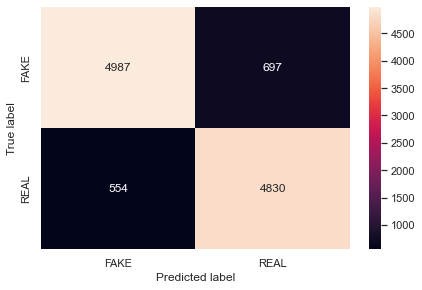

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

models = []

random_forest = Pipeline([("m", RandomForestClassifier())])
models.append(("random_forest", random_forest))

logistic_regression = Pipeline([("m", LogisticRegression())])
models.append(("logistic_regression", logistic_regression))

knn = Pipeline([("m", KNeighborsClassifier())])
models.append(("knn", knn))

ensemble_model = VotingClassifier(estimators=models, voting="hard")
train_evaluate_model(ensemble_model, "sklearn")

## Voting Classifier (Random Forests, Decision Trees, Gaussian Naive Bayes)

Total Training Time: 41.579813000000286

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      5684
           1       0.92      0.94      0.93      5384

    accuracy                           0.93     11068
   macro avg       0.93      0.93      0.93     11068
weighted avg       0.93      0.93      0.93     11068



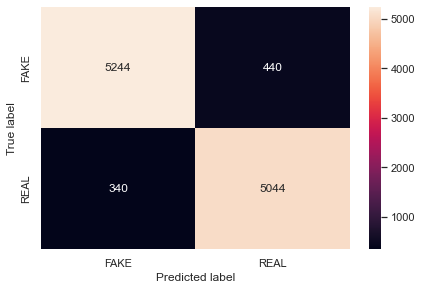

In [58]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline

models = []

random_forest = Pipeline([("m", RandomForestClassifier())])
models.append(("random_forest", random_forest))

decision_tree = Pipeline([("m", DecisionTreeClassifier())])
models.append(("decision_tree", decision_tree))

naive_bayes = Pipeline([("m", GaussianNB())])
models.append(("naive_bayes", naive_bayes))

ensemble_model = VotingClassifier(estimators=models, voting="hard")
train_evaluate_model(ensemble_model, "sklearn")